<a href="https://colab.research.google.com/github/paulagiovanna/IC---Covid19-Random-Walk/blob/master/draw_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

!sudo apt-get install libgeos-3.5.0
!sudo apt-get install libgeos-dev
!sudo pip install https://github.com/matplotlib/basemap/archive/master.zip


In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.basemap import Basemap as Basemap

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Lê a matriz de transição resultante do código 'random_walk.ipynb'

In [2]:
transition_matrix = pd.read_csv('jan-media_voos.csv')
transition_matrix = transition_matrix[['org', 'dest', 'valor_norm']]
transition_matrix = transition_matrix.rename(columns={'org': 'source', 'dest': 'target', 'valor_norm':'value'})
transition_matrix.head()

source   target      value
0  Algeria  Austria   1.000000
1  Algeria  Belgium   1.275510
2  Algeria   Canada   1.000000
3  Algeria   France  12.272727
4  Algeria  Germany   1.560345

Lê o vetor de estados resultante do código 'random_walk.ipynb'

In [3]:
state_vector =  pd.read_csv('state_vector.csv')
state_vector = state_vector.set_index("target")
state_vector.head()

n_cases
target              
Algeria    24.357881
Anguilla    0.001828
Argentina  43.959550
Armenia     1.443410
Aruba       3.927098

Lê as latitudes e longitudes dos países

In [4]:
lat_long =  pd.read_csv('lat_long.csv', sep=";")
lat_long = lat_long.set_index("name")
lat_long = lat_long.drop(columns=['country'])

Transforma a matriz de transição em um grafo

In [5]:
G=nx.from_pandas_edgelist(transition_matrix, source='source', target='target', edge_attr='value')
probs = [i['value'] for i in dict(G.edges).values()]
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}

Calcula a centralidade de auto vetor

In [6]:
centrality = nx.eigenvector_centrality(G)
centrality_df = pd.DataFrame(centrality.keys(),columns=['country'])
centrality_df['centrality'] = centrality.values()
centrality_df = centrality_df.set_index('country')

In [7]:
centrality_df.to_csv('eigenvector_centrality.csv')
centrality_df.head()

centrality
country                   
Canada            0.123904
Brazil            0.085978
Qatar             0.168160
Italy             0.179904
Czech Republic    0.138169

Principais arestas do grafo printadas em um mapa preto e branco

In [8]:
transition_matrix_sorted = transition_matrix.sort_values(by='value', ascending=False).reset_index()

#6000 traz todas as edges
top_edges = transition_matrix_sorted.index < 6000
main_edges = list(transition_matrix_sorted[top_edges].drop(columns=['index', 'value']).to_records(index=False))
main_edges_values = []

for x in transition_matrix_sorted[top_edges]['value']:
    main_edges_values.append(x/10.)


In [9]:
weight = []
for node in G.nodes():
    weight.append(centrality_df.loc[node, 'centrality']*5000)

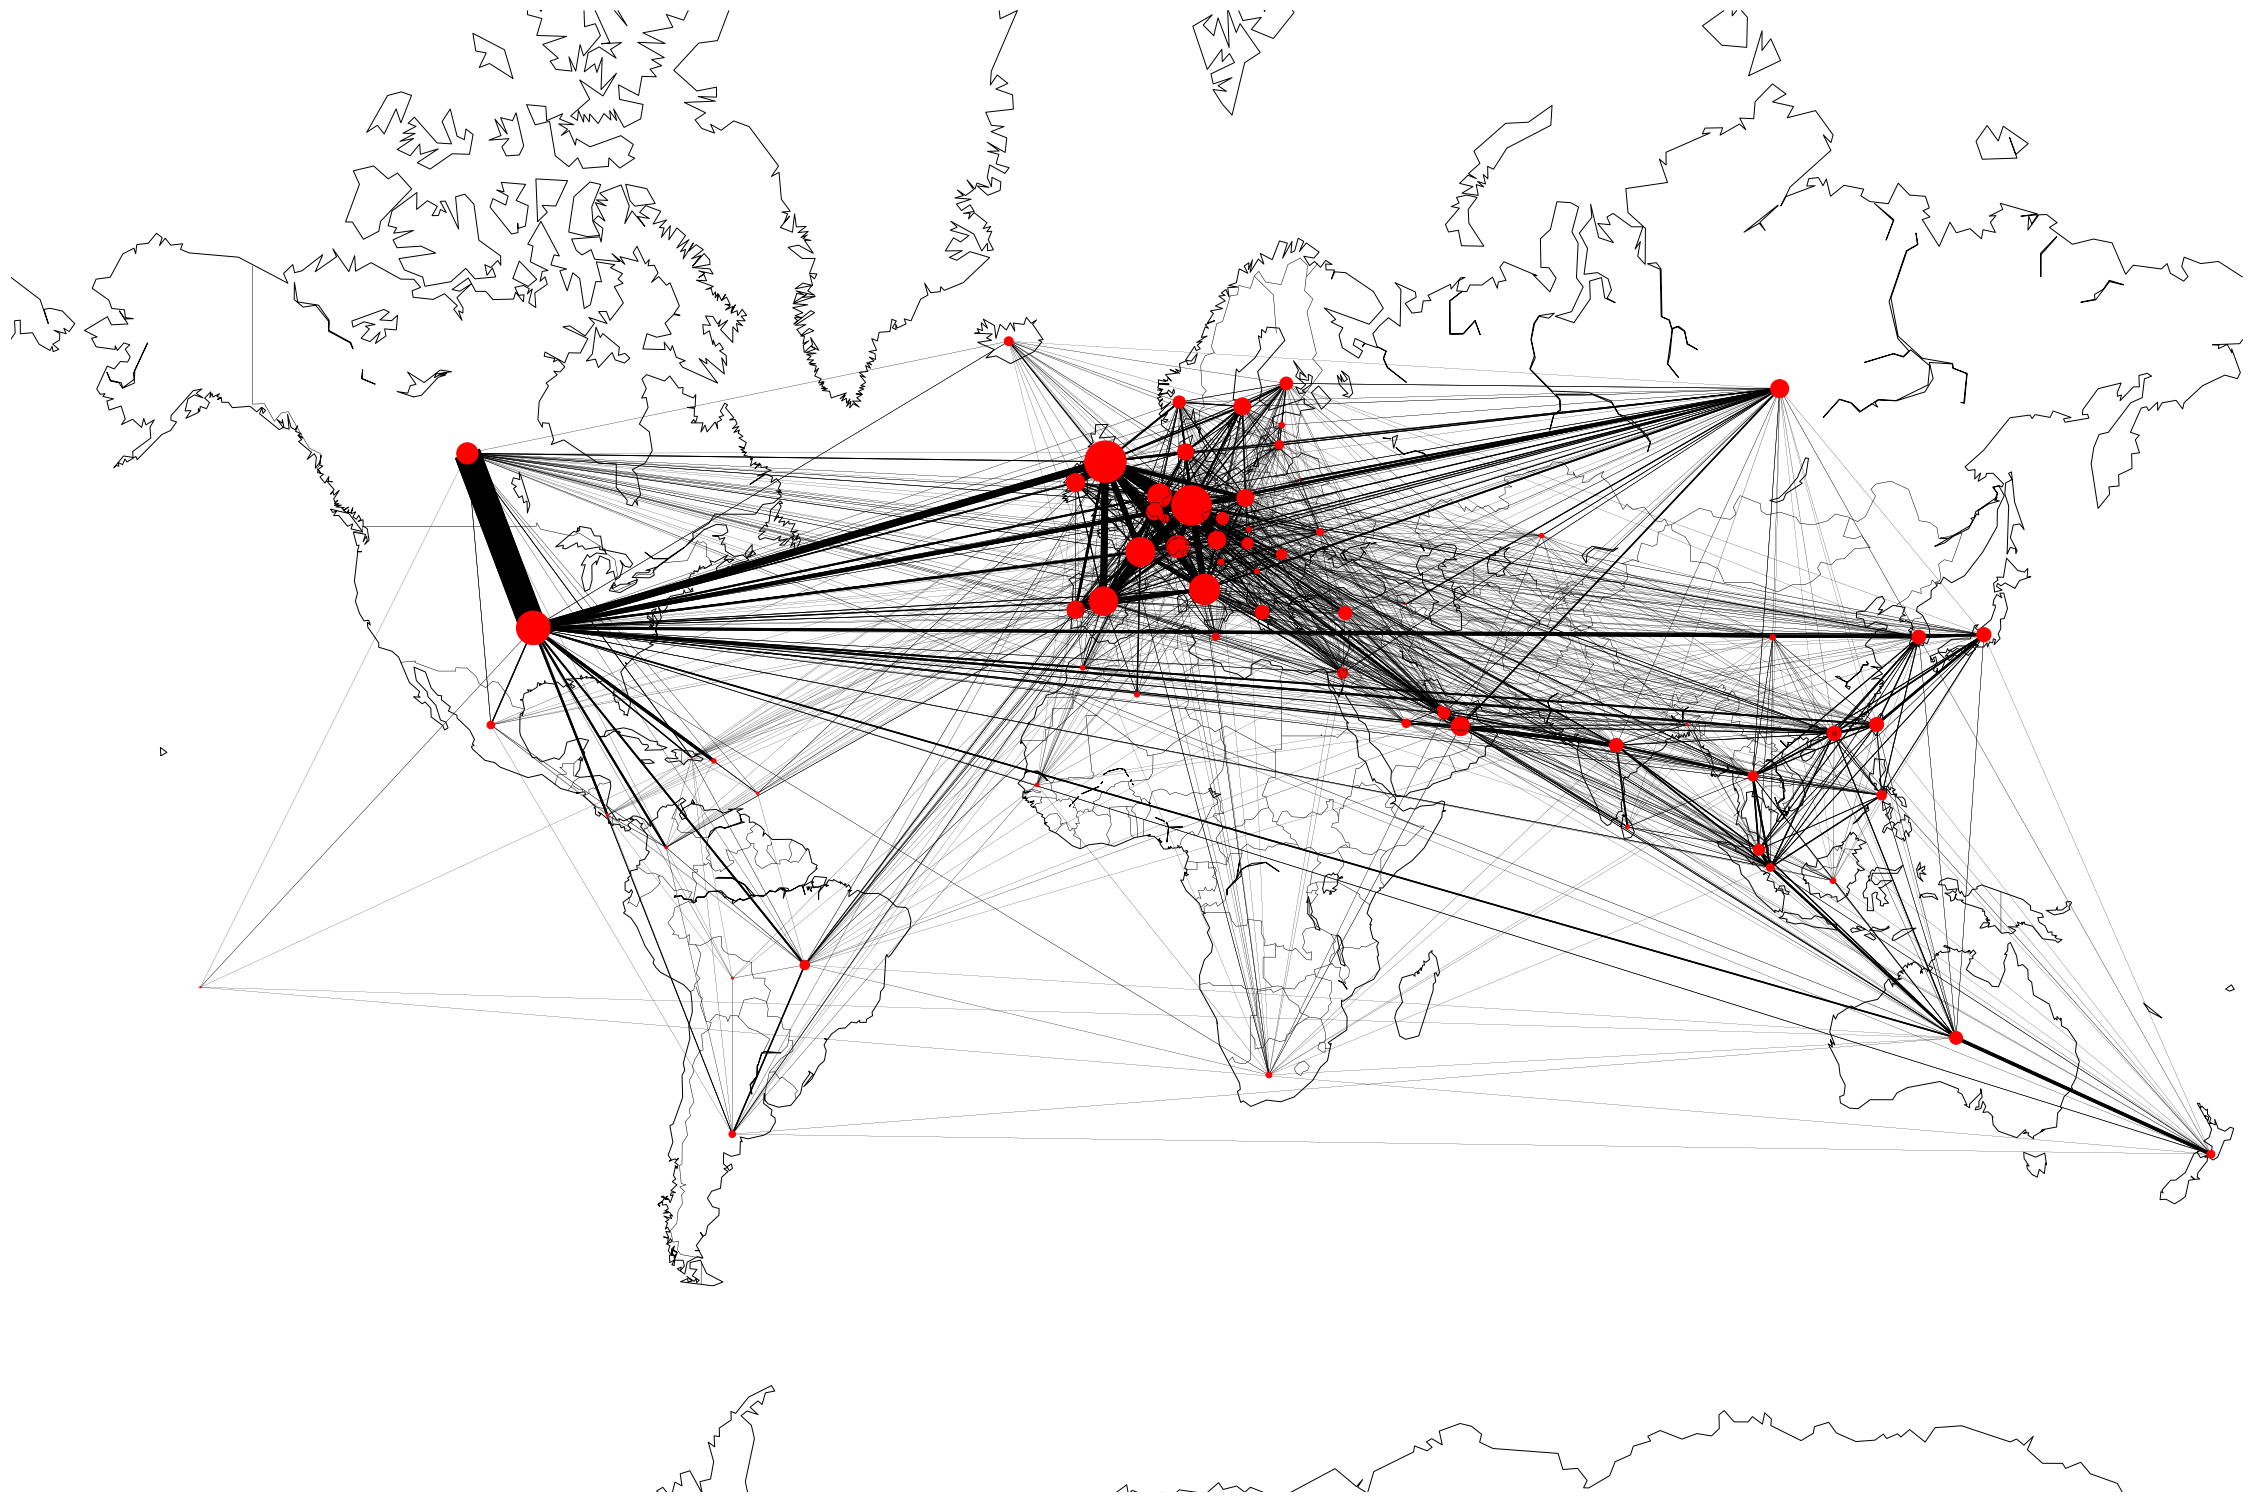

In [18]:
m = Basemap(projection='merc',llcrnrlat=-70,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

m.drawcoastlines()

country_list = transition_matrix['source'].unique()
pos={}

for country in country_list:
  pos[country] = (m(float(lat_long.loc[country, 'longitude']),float(lat_long.loc[country, 'latitude'])))

nx.draw(G,pos,node_size=weight,edgelist=main_edges,width=main_edges_values)

m.drawcountries()
mpl.rcParams['figure.figsize'] = [40, 40]
plt.savefig("uncolored_graph_edges")

Nós do grafo com o resultado do state vector printados em um grafo 'estilizado'

In [11]:
weight = []
for node in G.nodes():
    weight.append(state_vector.loc[node, 'n_cases'])

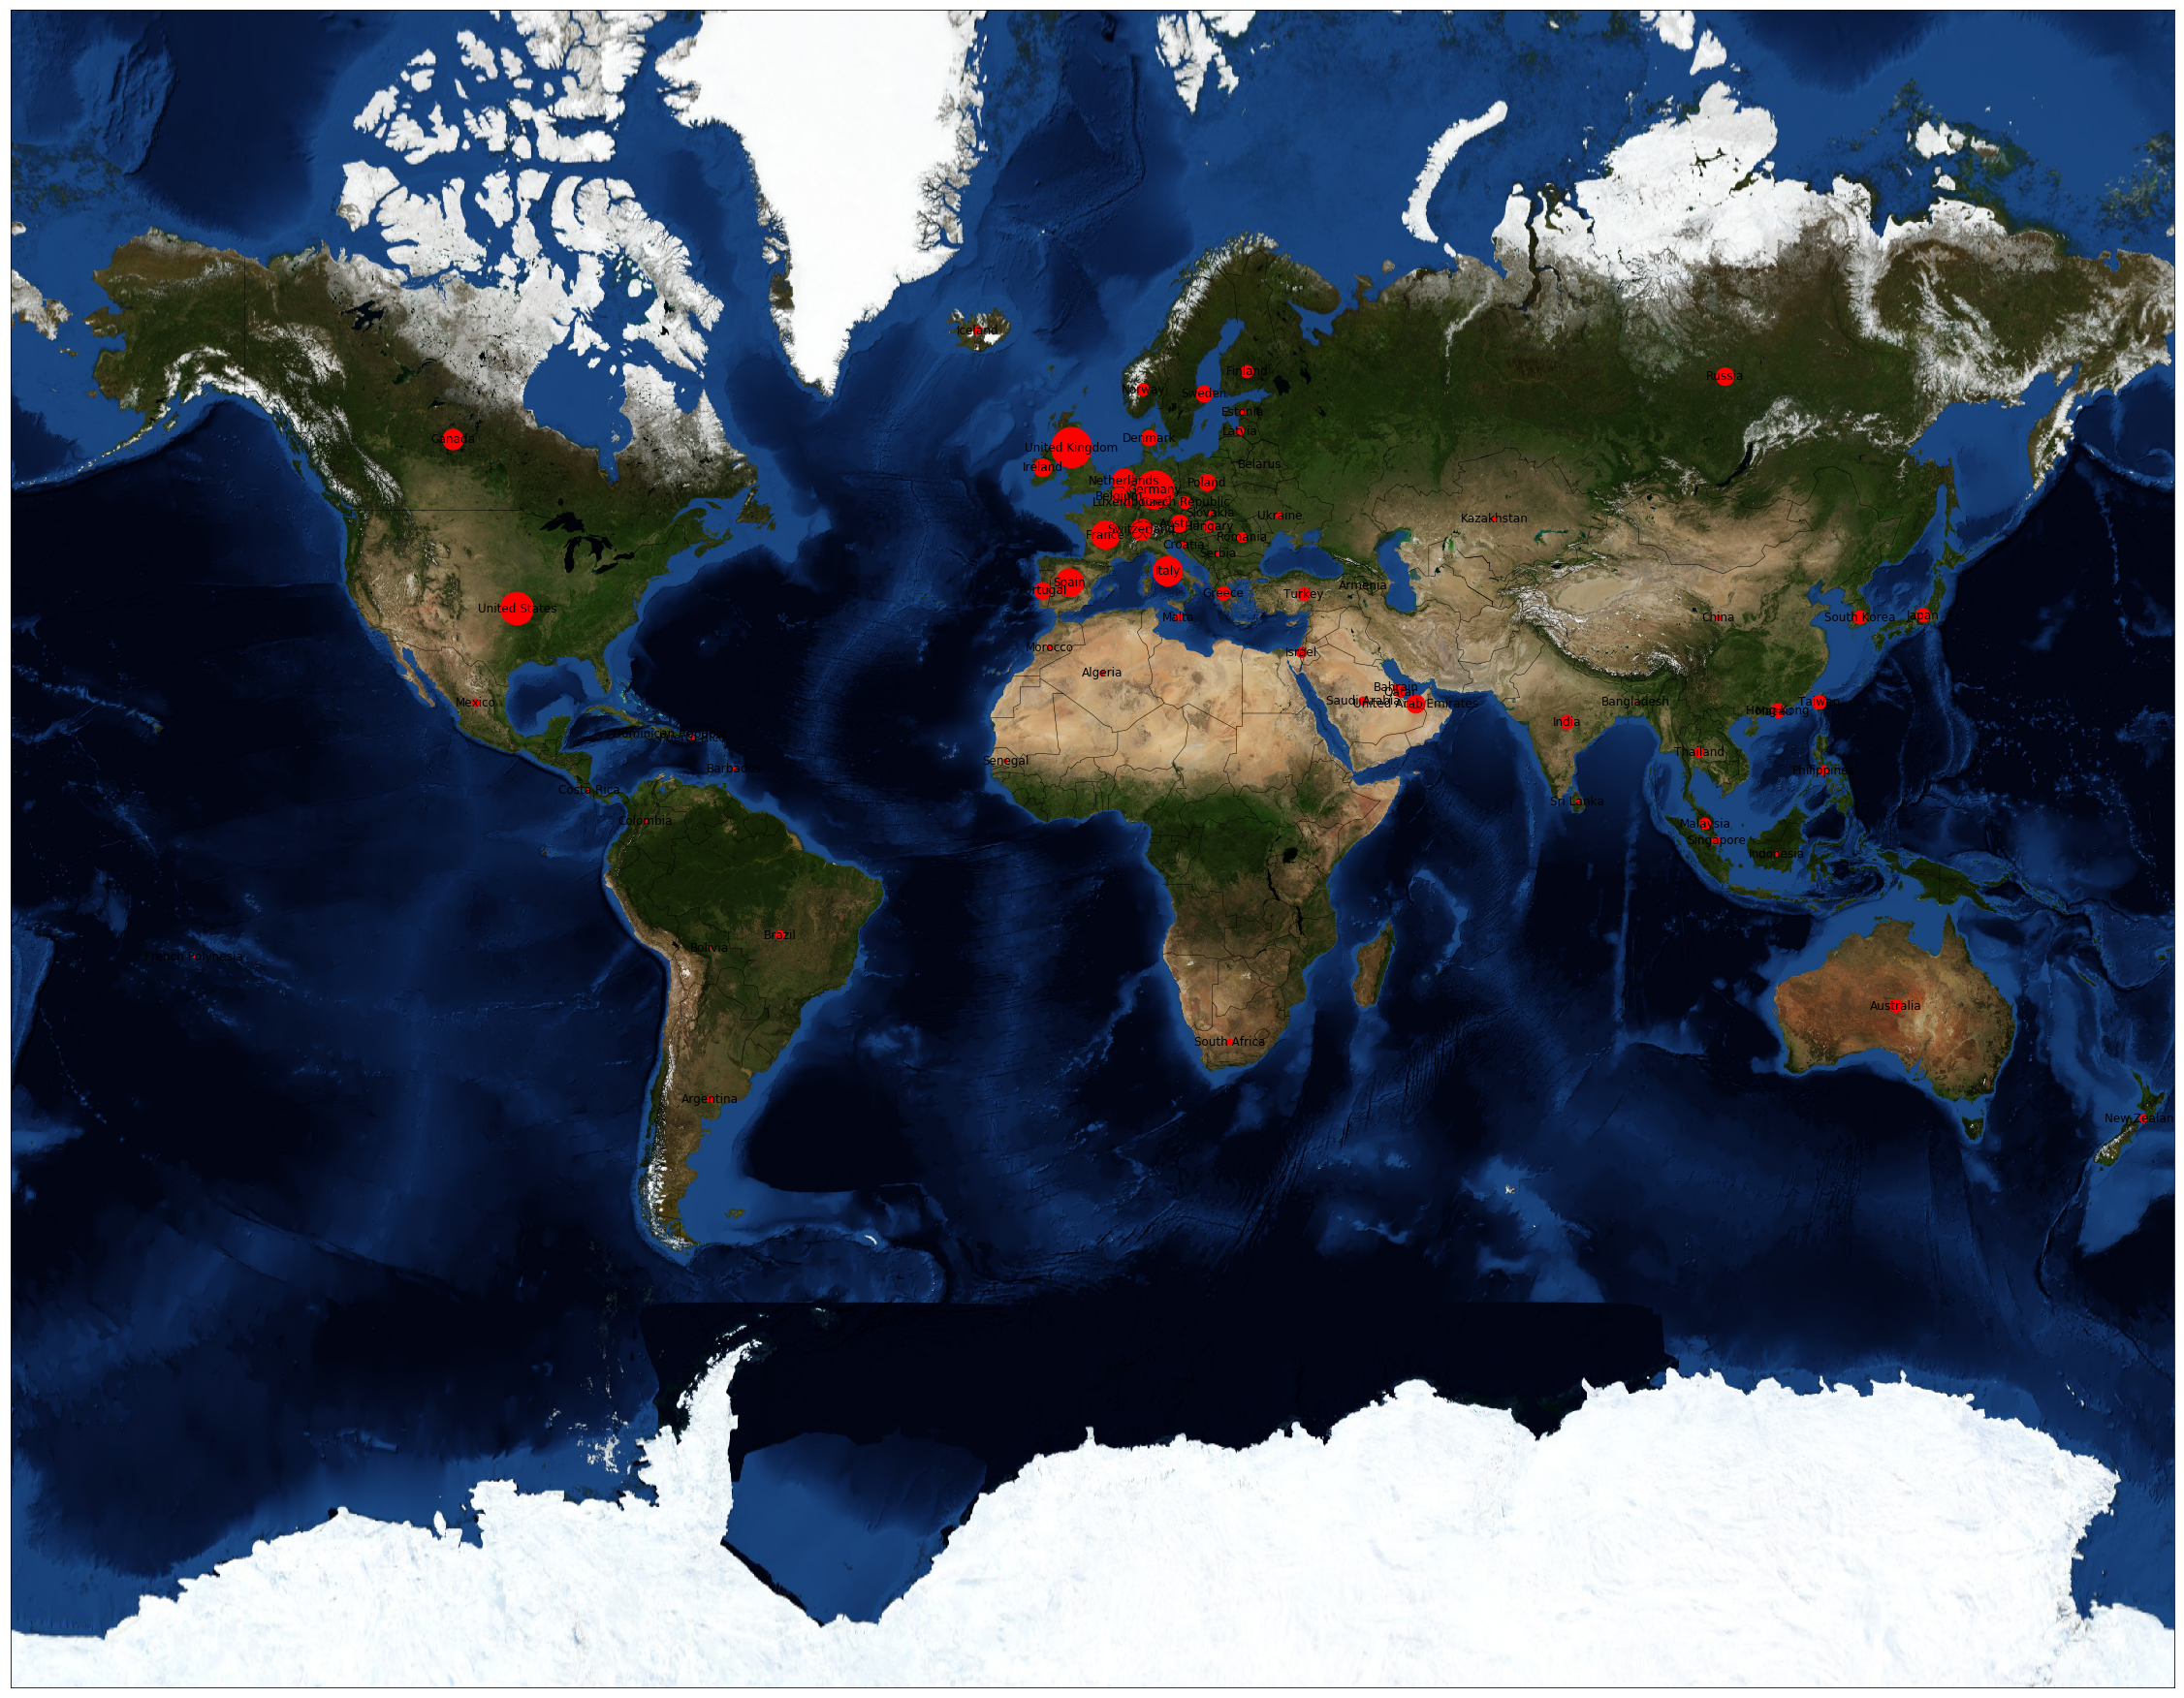

In [12]:
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

country_list = state_vector.index.unique()
pos={}

for country in country_list:
  pos[country] = (m(float(lat_long.loc[country, 'longitude']),float(lat_long.loc[country, 'latitude'])))

nx.draw_networkx(G,pos,node_size=weight, edgelist=[])

m.drawcountries()
m.bluemarble()
mpl.rcParams['figure.figsize'] = [40, 40]
plt.savefig("colored_graph_nodes")